# Keyword Classification

## Import Librarys 

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

## Import Data

In [366]:
keywords = pd.read_csv('keywords_categories.csv', encoding = "ISO-8859-1")

#https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python

## EDA

https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py

Number of samples

In [344]:
print(f'Total number of samples = {len(keywords)} keywords')

Total number of samples = 10084 keywords


Number of keywords per class

In [345]:
classes = keywords.pivot_table('keyword', index = 'category', aggfunc='count').sort_values(by='keyword', ascending=False)

In [346]:
classes

,keyword
category,
monotype,2188
font technology,1740
fonts by vertical,936
font,813
html5,703
digital advertising,586
emoji,547
font type,488
mobile advertising,457


Number of words per sample

In [347]:
num_words = [len(s.split()) for s in keywords.keyword]

In [348]:
np.median(num_words)

3.0

Distribution of n-grams

In [349]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=[30,5])
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

/home/lee/.local/share/virtualenvs/keyword_classifier-6oEb6Vw0/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


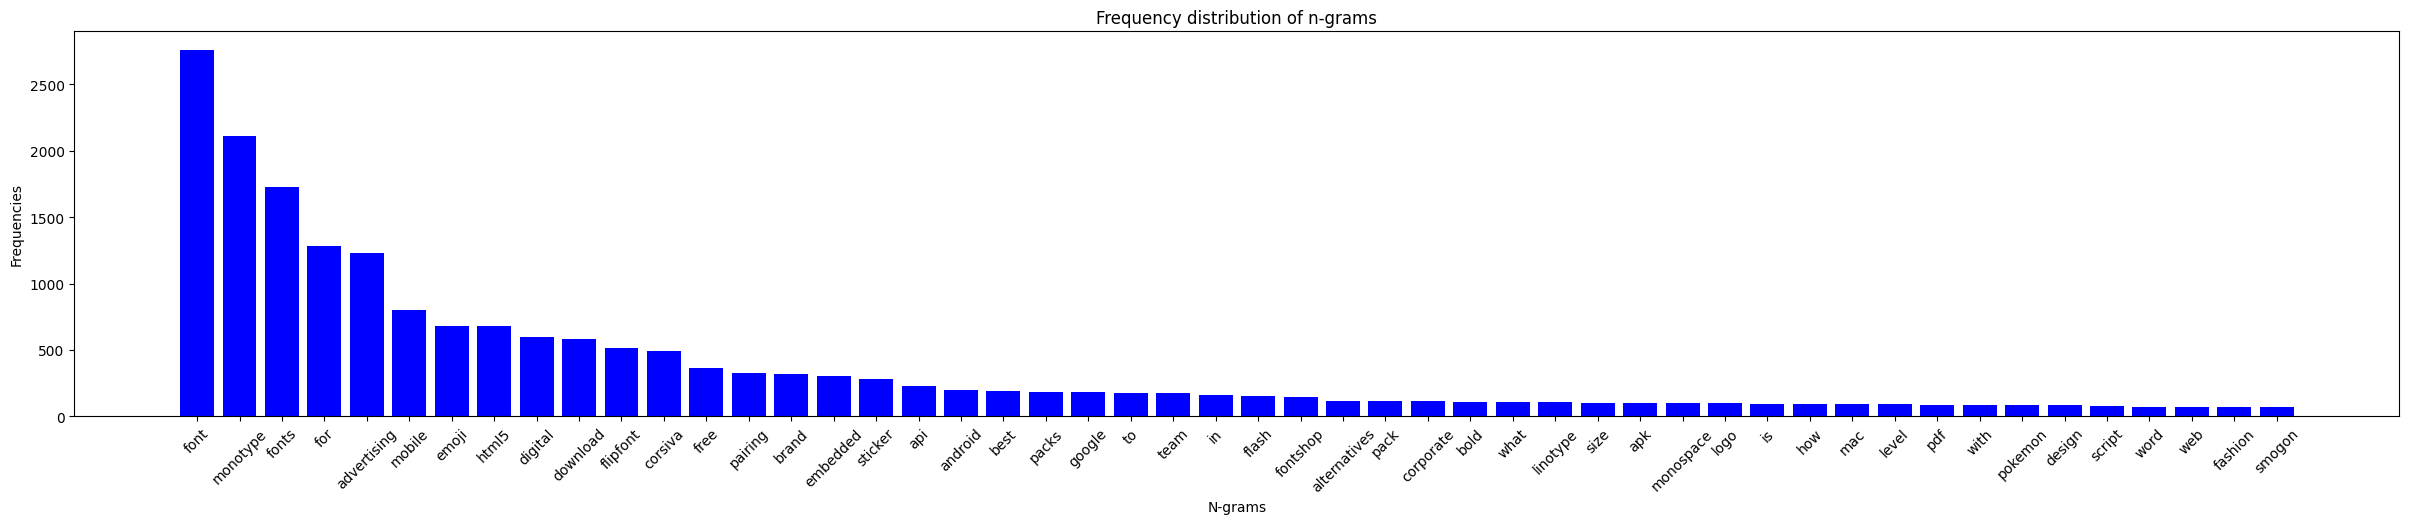

In [350]:
plot_frequency_distribution_of_ngrams(keywords.keyword)

Sample Length Distribution

In [304]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.figure(figsize=[10,5])
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample (chars)')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

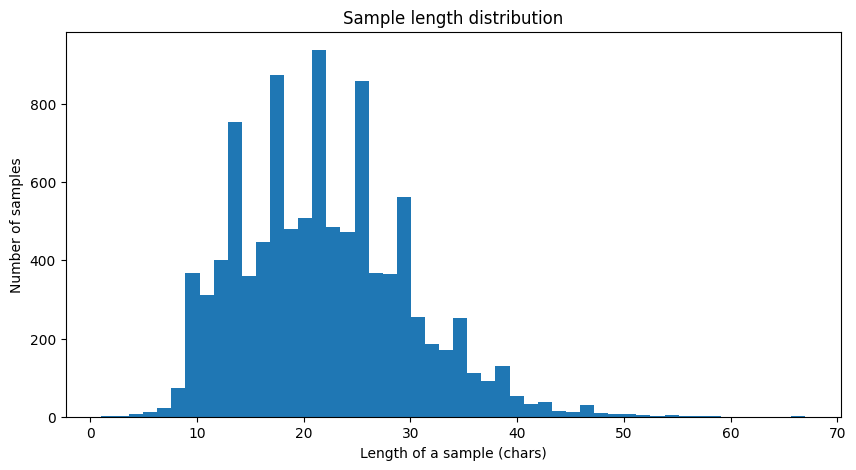

In [305]:
plot_sample_length_distribution(keywords.keyword)

Class Distribution

<AxesSubplot:xlabel='category'>

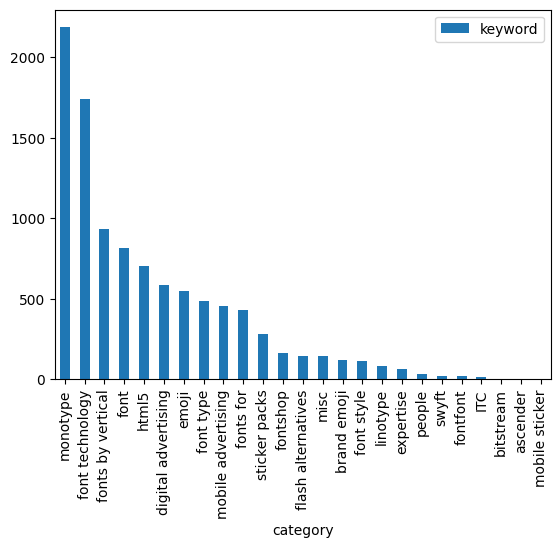

In [306]:
classes.plot.bar()

In [307]:
#TODO:Need to think about rewriting these exploratory scripts into something more succinct.

## Data Leakage

In [367]:
data_leakage = [row for row in zip(keywords.keyword,keywords.category) if row[0] == row[1]]
data_leakage_df = pd.DataFrame(columns = ['keyword', 'category'], data=data_leakage)

In [368]:
keywords = keywords[~(keywords.keyword + keywords.category).isin(data_leakage_df.keyword + data_leakage_df.category)]

## Class Imbalance

https://elitedatascience.com/imbalanced-classes

In [369]:
keywords

,keyword,category
0,writing fonts,font type
1,word fonts,font type
2,windows fonts,font type
3,wedding fonts,font type
4,wedding font,font type
...,...,...
10057,sticker pack yamaha bws 125,sticker packs
10058,sticker pack.zip,sticker packs
10059,obey sticker pack zumiez,sticker packs
10060,barbie stickerzine packs,sticker packs


In [370]:
item_counts = keywords.category.value_counts()
item_counts

monotype               2185
font technology        1739
fonts by vertical       936
font                    813
html5                   702
digital advertising     585
emoji                   546
font type               488
mobile advertising      456
fonts for               428
sticker packs           280
fontshop                165
misc                    142
brand emoji             118
flash alternatives      115
font style              112
linotype                 81
expertise                62
people                   32
swyft                    23
fontfont                 18
ITC                      15
bitstream                 4
ascender                  3
mobile sticker            1
Name: category, dtype: int64

### Rolling any class less < 100 into misc. 

In [371]:
for index,item in enumerate(keywords.category):
    if item_counts.loc[item]<100:
        keywords.category.iloc[index]='misc'

In [372]:
item_counts = keywords.category.value_counts()
item_counts

monotype               2185
font technology        1739
fonts by vertical       936
font                    813
html5                   702
digital advertising     585
emoji                   546
font type               488
mobile advertising      456
fonts for               428
misc                    381
sticker packs           280
fontshop                165
brand emoji             118
flash alternatives      115
font style              112
Name: category, dtype: int64

Up sample Minorty Classes

In [373]:
def upsample(class_list, dataframe):
    frames = {}
    frames_upsampled = {}
    for index,item in enumerate(class_list):
        frames[item]= dataframe[dataframe.category == class_list[index]]
    for index,item in enumerate(class_list):
        frames_upsampled[item] = resample(frames[item], replace=True, 
        n_samples = 2185, random_state = 42)
    upsampled_df = pd.concat(frames_upsampled.values(), ignore_index=True)
    return upsampled_df
    

In [374]:
upsampled = upsample(item_counts.index.tolist(), keywords)

Down sample majority classes

In [375]:
def downsample(class_list, dataframe):
    frames = {}
    frames_downsampled = {}
    for index,item in enumerate(class_list):
        frames[item]= dataframe[dataframe.category == class_list[index]]
    for index,item in enumerate(class_list):
        frames_downsampled[item] = resample(frames[item], replace=True, 
        n_samples = 112, random_state = 42)
    downsampled_df = pd.concat(frames_downsampled.values(), ignore_index=True)
    return downsampled_df

In [376]:
frames = downsample(item_counts.index.tolist(), keywords)

In [377]:
def sample(upsample = False, class_list = None, dataframe = None):
    frames = {}
    frames_sampled = {}
    if upsample:
        for index,item in enumerate(class_list):
            frames[item]= dataframe[dataframe.category == class_list[index]]
        for index,item in enumerate(class_list):
            frames_sampled[item] = resample(frames[item], 
            replace=True, n_samples = XXX, random_state = 42)
        sampled_df = pd.concat(frames_sampled.values(), ignore_index=True)
    else:
        for index,item in enumerate(class_list):
            frames[item]= dataframe[dataframe.category == class_list[index]]
        for index,item in enumerate(class_list):
            frames_sampled[item] = resample(frames[item], replace=True,
            n_samples = XXX, random_state = 42)
        sampled_df = pd.concat(frames_sampled.values(), ignore_index=True)
    return sampled_df

In [378]:
#TODO:[] combine these functions into one - IN PROGRESS
#TODO:[] add an ability to detect the sample size if upsampling or downsampling are required
#TODO:[] compare distributions of sampled data compared to original data 

## Train, Test, Validation Split

https://machinelearningmastery.com/difference-test-validation-datasets/

In [379]:
X = upsampled.keyword
y = upsampled.category
X_train, X_remainder, y_train, y_remainder = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_remainder, y_remainder, test_size = 0.5, random_state = 42)

In [16]:
X_train

8356                       joanna nova
10368              how html5 is better
18123     mobile advertising on wheels
23174                     online fonts
4043             flipfont pack mobile9
                     ...              
16850    corporate communications font
6265           font for clothing brand
11284        digital advertising world
860                 monotype font list
15795                      design font
Name: keyword, Length: 24472, dtype: object

In [17]:
y_train

8356                    font
10368                  html5
18123     mobile advertising
23174                   misc
4043         font technology
                ...         
16850              font type
6265       fonts by vertical
11284    digital advertising
860                 monotype
15795              font type
Name: category, Length: 24472, dtype: object

In [18]:
X_test

8474                                       bank gothic
14876                             emoji happy birthday
12167                    digital advertising rate card
26071    how to use sticker packs in plants vs zombies
6676                                        unite font
                             ...                      
28574                        flash powder alternatives
28210                                   font shop free
13332                                emoji throwing up
29979                 adobe flash builder alternatives
21415                              fonts for windows 8
Name: keyword, Length: 5244, dtype: object

In [19]:
y_test

8474                    font
14876                  emoji
12167    digital advertising
26071          sticker packs
6676                    font
                ...         
28574     flash alternatives
28210               fontshop
13332                  emoji
29979     flash alternatives
21415              fonts for
Name: category, Length: 5244, dtype: object

In [20]:
X_val

28549      ubuntu flash alternative to adobe
12073          digital advertising buzzwords
34439                       historical fonts
16533              custom font design online
15789                  corporate font family
                        ...                 
1444                         monotype en art
31519                  emoji brand main game
25689                animal sticker pack bmx
13244                           emoji x eyes
17705    mobile advertising public companies
Name: keyword, Length: 5244, dtype: object

In [21]:
y_val

28549     flash alternatives
12073    digital advertising
34439             font style
16533              font type
15789              font type
                ...         
1444                monotype
31519            brand emoji
25689          sticker packs
13244                  emoji
17705     mobile advertising
Name: category, Length: 5244, dtype: object

## Data Preparation

In [22]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), dtype= 'int32', strip_accents= 'unicode', decode_error='replace', analyzer= 'word', min_df= 2)

In [23]:
x_train = vectorizer.fit_transform(X_train)

/home/lee/.local/share/virtualenvs/keyword_classifier-6oEb6Vw0/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [24]:
x_test = vectorizer.transform(X_test)

In [25]:
selector = SelectKBest(f_classif, k=min(20000, x_train.shape[1]))

In [26]:
selector.fit(x_train,y_train)

SelectKBest(k=8518)

In [27]:
x_train = selector.transform(x_train).astype('float32')
x_test = selector.transform(x_test).astype('float32')

In [28]:
x_train

<24472x8518 sparse matrix of type '<class 'numpy.float32'>'
	with 132071 stored elements in Compressed Sparse Row format>

In [29]:
x_test

<5244x8518 sparse matrix of type '<class 'numpy.float32'>'
	with 27448 stored elements in Compressed Sparse Row format>

## Using a Gradient Boosted Decision Tree as a Baseline

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=30, random_state=42).fit(x_train, y_train)

In [364]:
clf.score(x_test,y_test)

0.9361174675819984

In [380]:
clf.score(X_val,y_val)

ValueError: could not convert string to float: 'brand emoji cheats'

Check for overfitting here

In [395]:
query = ["custom fonts"]

In [396]:
query_vec = vectorizer.transform(query)

In [397]:
query_vec_op = selector.transform(query_vec).astype('float32')

In [398]:
clf.predict(query_vec_op)

array(['font type'], dtype=object)

In [399]:
clf.predict_proba(query_vec_op).max()

1.0

Use Monotype 2015 site for comparison:- https://web.archive.org/web/20151118070642/http://www.monotype.com/fonts/custom-fonts

## Hyperparameter Optimisation


In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
parameters = {'n_estimators':[100, 200, 300, 400, 500],
              'max_depth':[10,15,20,25,30,35,40]}

In [44]:
clf_op = GridSearchCV(GradientBoostingClassifier(learning_rate=1.0, random_state=42), parameters, n_jobs=-1, verbose=3)

In [45]:
clf_op.fit(x_train,y_train)







Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END ....max_depth=10, n_estimators=100;, score=0.941 total time= 3.9min
[CV 2/5] END ....max_depth=10, n_estimators=100;, score=0.934 total time= 4.2min
[CV 5/5] END ....max_depth=10, n_estimators=100;, score=0.919 total time= 4.3min
[CV 4/5] END ....max_depth=10, n_estimators=100;, score=0.898 total time= 4.5min
[CV 3/5] END ....max_depth=10, n_estimators=100;, score=0.915 total time= 4.7min
[CV 1/5] END ....max_depth=10, n_estimators=200;, score=0.942 total time= 7.6min
[CV 5/5] END ....max_depth=10, n_estimators=200;, score=0.919 total time= 7.9min
[CV 2/5] END ....max_depth=10, n_estimators=200;, score=0.933 total time= 8.0min
[CV 3/5] END ....max_depth=10, n_estimators=200;, score=0.917 total time= 8.3min
[CV 4/5] END ....max_depth=10, n_estimators=200;, score=0.902 total time= 9.9min
[CV 2/5] END ....max_depth=10, n_estimators=300;, score=0.934 total time=11.5min
[CV 1/5] END ....max_depth=10, n_estimators=300